In [2]:
#step 1: split the image to R,G,B
#step 2: split the each component to 8*8 blocks
#step 3: Do 2d DCT
#step 4: take m*m from 1 to 4 of coefficients of the block from the top left 
#step 5: do idct
#step 6: calculate the error
#step 7: compare the results for each m 

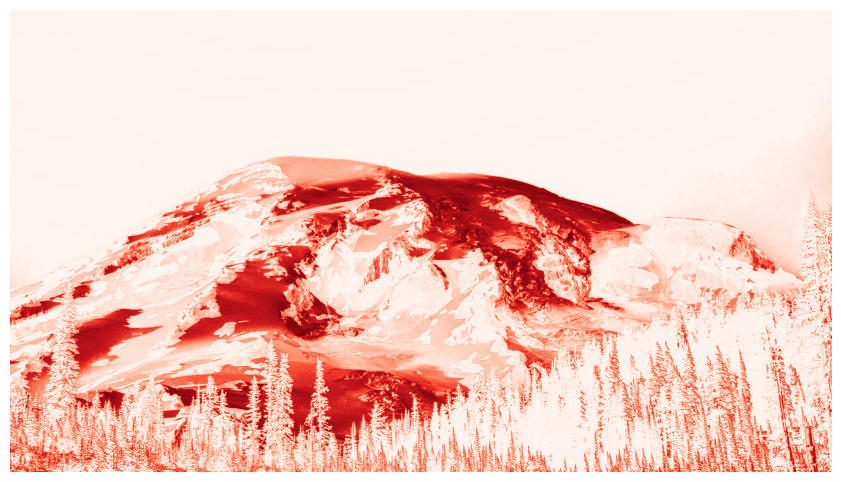

In [2]:
import os
import cv2
import sys
import numpy as np
from scipy.fftpack import dct, idct
from math import log10
import matplotlib.pyplot as plt
class ImageCompressor:
    @staticmethod
    def dct_2d(processed_block):
        """
        Computes the 2D Discrete Cosine Transform (DCT) of a given block.

        Parameters:
            processed_block (numpy.ndarray): Input block (8x8).

        Returns:
            numpy.ndarray: 2D DCT of the input block.
        """
        return dct(dct(processed_block.T, norm='ortho').T, norm='ortho')

    @staticmethod
    def idct_2d(processed_block):
        """
        Computes the inverse 2D Discrete Cosine Transform (IDCT) of a given block.

        Parameters:
            processed_block (numpy.ndarray): Input block (8x8).

        Returns:
            numpy.ndarray: Inverse 2D DCT of the input block.
        """
        return idct(idct(processed_block.T, norm='ortho').T, norm='ortho')

    @staticmethod
    def compress(image, m):
        """
        Compresses an image by retaining only the top-left m x m DCT coefficients of each 8x8 block.

        Parameters:
            image (numpy.ndarray): Input image (height x width x channels).
            m (int): Number of coefficients to retain.

        Returns:
            numpy.ndarray: Compressed image with retained DCT coefficients.
        """
        blocks_shape = (image.shape[0] // 8, image.shape[1] // 8)
        compressed_image = np.zeros((m * blocks_shape[0], m * blocks_shape[1], 3))
        for channel in range(3):
            for row in range(blocks_shape[0]):
                for col in range(blocks_shape[1]):
                    processed_block = image[8 * row:8 * (row + 1), 8 * col:8 * (col + 1), channel]
                    dct_block = ImageCompressor.dct_2d(processed_block)
                    dct_retained_block = dct_block[:m, :m]
                    compressed_image[m * row:m * (row + 1), m * col:m * (col + 1), channel] = dct_retained_block
        return compressed_image

    @staticmethod
    def decompress(compressed_image, m):
        """
        Decompresses an image by performing inverse DCT and reconstructing blocks.

        Parameters:
            compressed_image (numpy.ndarray): Compressed image with retained DCT coefficients.
            m (int): Number of coefficients retained during compression.

        Returns:
            numpy.ndarray: Decompressed image.
        """
        blocks_shape = (compressed_image.shape[0] // m, compressed_image.shape[1] // m)
        decompressed_image = np.zeros((8 * blocks_shape[0], 8 * blocks_shape[1], 3))
        for channel in range(3):
            for row in range(blocks_shape[0]):
                for col in range(blocks_shape[1]):
                    processed_block = np.zeros((8, 8))
                    processed_block[:m, :m] = compressed_image[m * row:m * (row + 1), m * col:m * (col + 1), channel]
                    idct_block = ImageCompressor.idct_2d(processed_block)
                    decompressed_image[8 * row:8 * (row + 1), 8 * col:8 * (col + 1), channel] = idct_block
        return decompressed_image

    @staticmethod
    def psnr(input_image, decompressed_image):
        """
        Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

        Parameters:
            input_image (numpy.ndarray): Original input image.
            decompressed_image (numpy.ndarray): Decompressed image.

        Returns:
            float: PSNR value.
        """
        SE = (input_image - decompressed_image) ** 2
        MSE = np.mean(SE)
        peak = 255
        PSNR = 10 * log10((peak ** 2) / MSE)
        return PSNR

    @staticmethod
    def visualize_components(input_image):
        """
        Visualizes and saves the color components of an image.

        Parameters:
            input_image (numpy.ndarray): Input image.

        Returns:
            None
        """
        os.makedirs("Image Components", exist_ok=True)
        colors = ["Reds", "Greens", "Blues"]
        for i in range(3):
            plt.figure(figsize=(14, 6))
            plt.axis("on")
            plt.imshow(input_image[:, :, 2 - i], cmap=colors[i]);
            plt.axis("off")
            plt.savefig(f"Image Components/{colors[i][:-1].lower()} channel.png");

    @staticmethod
    def run(image_path, m):
        """
        Executes the project tasks including compression, decompression, PSNR calculation, and plotting.

        Parameters:
            image_path (str): Path to the input image.
            m (int): Number of coefficients to retain.

        Returns:
            None
        """
        # Open a file to write results
        with open('sizes.txt', 'w') as file:
            # Read the input image
            input_image_array = cv2.imread(image_path)
            
            # Visualize the components of the input image
            ImageCompressor.visualize_components(input_image_array)
            
            # Create directories for storing compressed and decompressed images if they don't exist
            os.makedirs("Decompressed Images", exist_ok=True)
            os.makedirs("Compressed Images", exist_ok=True)
            
            # Write the original size of the image to the file
            file.write(f"Original Image Size : {os.path.getsize(image_path) / (1024 ** 2):.2f} MB\n")
            
            # Initialize an array to store PSNR values
            PSNRS = np.zeros(m)
            
            # Compress and decompress the image for different compression levels
            for i in range(1, m + 1):
                # Compress the image
                compressed_image = ImageCompressor.compress(input_image_array, i)
                 
                cv2.imwrite(f'Compressed Images/compressedImageWithM{i}.png', compressed_image)
                
                # Decompress the image
                decompressed_image = ImageCompressor.decompress(compressed_image, i)
                
                # Write image information and calculate PSNR
                PSNR = ImageCompressor.write_image_info(file, os.path.getsize(f'Compressed Images/compressedImageWithM{i}.png') / (1024 ** 2),
                                                        input_image_array, decompressed_image, i)
                # Store PSNR value
                PSNRS[i - 1] = PSNR
                
                # Save the decompressed image
                cv2.imwrite(f"Decompressed Images/decompressedImageWithM{i}.png", decompressed_image)
                
            
            # Plot PSNR values
            ImageCompressor.plot_PSNRS(m, PSNRS)

    @staticmethod
    def write_image_info(file, size_in_MB, input_image, decompressed_image, m):
        """
        Writes image compression information and PSNR value to a file.

        Parameters:
            file (file): File object to write information to.
            size_in_MB (float): Size of the compressed image in MB.
            input_image (numpy.ndarray): Original input image.
            decompressed_image (numpy.ndarray): Decompressed image.
            m (int): Number of coefficients retained during compression.

        Returns:
            float: PSNR value.
        """
        file.write(f"m = {m} :\n")
        file.write(f"Compressed Image Size: {size_in_MB:.2f} MB\n")
        PSNR = ImageCompressor.psnr(input_image, decompressed_image)
        file.write(f"PSNR: {PSNR:.2f} dB\n")
        file.write("\n")
        return PSNR

    @staticmethod
    def plot_PSNRS(m, PSNRS):
        """
        Plots PSNR values against m values and saves the plot as an image.

        Parameters:
            m (int): Number of coefficients to retain.
            PSNRS (numpy.ndarray): Array of PSNR values.

        Returns:
            None
        """
        all_ms = np.linspace(1, m, m, dtype=np.uint8)
        plt.figure(figsize=(14, 6))
        plt.plot(all_ms, PSNRS, marker='o')
        plt.xlabel("m")
        plt.ylabel("PSNR")
        plt.title("PSNR vs m")
        plt.grid(True)
        plt.savefig("PSNRGraph.png")

ImageCompressor.run("./image1.png", 4)


In [1]:
import os
from PIL import Image
import sys

def get_image_size(folder_path):
    total_size = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            filepath = os.path.join(folder_path, filename)
            try:
                with Image.open(filepath) as img:
                    width, height = img.size
                    size_mb = os.path.getsize(filepath) / (1024 ** 2)  
                    print(f"Image: {filename}, Size: {width}x{height}, {size_mb:.2f} MB")
                    total_size += size_mb
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    print(f"Total size of images in folder: {total_size:.2f} MB")

# Usage
folder_path = "Decompressed Images"
get_image_size(folder_path)


Image: decompressedImageWithM1.png, Size: 1920x1080, 0.60 MB
Image: decompressedImageWithM2.png, Size: 1920x1080, 2.10 MB
Image: decompressedImageWithM3.png, Size: 1920x1080, 2.41 MB
Image: decompressedImageWithM4.png, Size: 1920x1080, 2.59 MB
Total size of images in folder: 7.70 MB


In [9]:
import pandas as pd
import plotly.express as px
data = {
    'Image': ['M=1', 'M=2', 'M=3', 'M=4'],
    'Compressed Size (MB)': [0.02, 0.21, 0.43, 0.71],
    'Decompressed Size (MB)': [0.6, 2.1, 2.41, 2.59]
}

df = pd.DataFrame(data)
print(df)


  Image  Compressed Size (MB)  Decompressed Size (MB)
0   M=1                  0.02                    0.60
1   M=2                  0.21                    2.10
2   M=3                  0.43                    2.41
3   M=4                  0.71                    2.59


In [10]:
fig = px.bar(df, x='Image', y=['Compressed Size (MB)', 'Decompressed Size (MB)'],
             title='Compressed and Decompressed Sizes for Each M',
             labels={'value': 'Size (MB)', 'Image': 'M'},
             barmode='group', text='value')

# Show plot
fig.show()